# ARIMA Forecasting in aeon


Experimental functions. Note Im not sure the 

In [9]:
from aeon_benchmark.forecasting.arima import (get_fixed_stationary_arma_params, 
                                              make_statsforecast_df, 
                                              simulate_arma_data, 
stationary_arma_models)
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA as SM_ARIMA
from aeon.forecasting.stats import ARIMA as AeonARIMA
from statsforecast import StatsForecast
from statsforecast.models import ARIMA as SF_ARIMA
import warnings
warnings.filterwarnings("ignore")
import time, os
import matplotlib.pyplot as plt
import seaborn as sns

def compare_arma_forecasters(lengths, m=5, sigma=1.0, seed_base=0):
    """
    Compare forecasters over increasing series lengths.

    Parameters
    ----------
    lengths : list of int
        Series lengths to evaluate.
    m : int
        Repetitions per length.
    sigma : float
        Std dev of noise in simulated data.
    seed_base : int
        Base seed to ensure reproducibility.

    Returns
    -------
    pandas.DataFrame
        Average MSE and time per method per length.
    """
    results = []
    # Warm up for numba
    n = 100
    p_used =1
    q_used =1
    ar_params, ma_params, p, q = get_fixed_stationary_arma_params(stationary_arma_models, seed=100)
    y = simulate_arma_data(ar_params, ma_params, n_samples=n, sigma=sigma, seed=100)
    model = SM_ARIMA(y, order=(p_used, 0, q_used)).fit()
    aeon_model = AeonARIMA(p=p_used, d=0, q=q_used, use_constant=True).fit(y)
    df = make_statsforecast_df(y)
    sf = StatsForecast(models=[SF_ARIMA(order=(p_used, 0, q_used))], freq="H")
    forecast_df = sf.forecast(df=df, h=1)
    forecast = forecast_df.iloc[0]["ARIMA"]

    for n in lengths:
        print(" Beginning length ",n)
        for i in range(m):
            seed = seed_base + i + n * 1000

            # Generate parameters and data
            ar_params, ma_params, p, q = get_fixed_stationary_arma_params(stationary_arma_models, seed=seed)
            y = simulate_arma_data(ar_params, ma_params, n_samples=n, sigma=sigma, seed=seed)
            y = (y - np.mean(y)) / np.std(y)
            y_train = y[:-1]
            y_test = y[-1:]
            sm_time = time.time()
            sm_results =[]
            # --- Statsmodels ---
            for (name, p_used, q_used) in [("statsmodels_true", p, q), ("statsmodels_baseline", 1, 1)]:
                try:
                    t0 = time.time()
                    model = SM_ARIMA(y_train, order=(p_used, 0, q_used)).fit()
                    forecast = model.forecast(steps=1)[0]
                    t1 = time.time()
                    error = y_test[0] - forecast
                    mse = float(error ** 2)
                    results.append({"method": name, "n": n, "mse": mse, "time": t1 - t0})
                except Exception as e:
                    print("Statsmodels exception =  ",e)
            sf_time = time.time()
            # --- Statsforecast ---
            for (name, p_used, q_used) in [("statsforecast_true", p, q), ("statsforecast_baseline", 1, 1)]:
                try:
                    df = make_statsforecast_df(y_train)
                    t0 = time.time()
                    sf = StatsForecast(models=[SF_ARIMA(order=(p_used, 0, q_used))],
                                       freq="H")
                    forecast_df = sf.forecast(df=df, h=1)
                    forecast = forecast_df.iloc[0]["ARIMA"]
                    t1 = time.time()
                    error = y_test[0] - forecast
                    mse = float(error ** 2)
                    if p == p_used and q == q_used:
                        sf_mse = mse
                    results.append({"method": name, "n": n, "mse": mse, "time": t1-t0,"model": [p_used,q_used]})
                except Exception as e:
                    print("Stats forecast exception =  ",e)
            aeon_time = time.time()
            # --- Aeon ---
            for (name, p_used, q_used) in [("aeon_true", p, q), ("aeon_baseline", 1, 1)]:
                try:
                    t0 = time.time()
                    aeon_model = AeonARIMA(p=p_used, d=0, q=q_used, use_constant=True)
                    aeon_model.fit(y_train)
                    forecast = aeon_model.forecast_
                    t1 = time.time()
                    error = y_test[0] - forecast
                    mse = float(error ** 2)
                    results.append({"method": name, "n": n, "mse": mse, "time": t1-t0,"model": [p_used,q_used]})
                    if p == p_used and q == q_used and np.abs(mse-sf_mse)>10:
                        print("Occasionally Nelder-Mead fails terribly")
                        print(f"{mse} aeon {sf_mse} SF, length {n}, run {i} p ={p} q "
                              f"= {q} AR paras = {ar_params} MA params = {ma_params}")
                        print(f" series = {y} seed = {seed} AIC = {aeon_model.aic_} ")
                except Exception as e:
                    print("aeon forecast exception =  ",e)
                    traceback.print_exc()
    df_results = pd.DataFrame(results)
    return df_results

def plot_mse_and_runtime_by_library(df_results):
    """
    Plot MSE and total runtime for each library (statsmodels, statsforecast, aeon),
    separately for true and baseline models. Also print tables comparing
    statsforecast and aeon against statsmodels.

    Parameters
    ----------
    df_results : pd.DataFrame
        Must contain columns: ['method', 'n', 'mse', 'time']
    """
    sns.set(style="whitegrid", font_scale=1.2)
    df = df_results.copy()

    # Extract library and model type (true or baseline)
    df["library"] = df["method"].str.extract(r"^(statsmodels|statsforecast|aeon)")
    df["model_type"] = df["method"].str.extract(r"_(true|baseline)")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

    for i, (metric, agg) in enumerate([("mse", "mean"), ("time", "sum")]):
        for j, model_type in enumerate(["true", "baseline"]):
            ax = axes[i, j]
            data = df[df["model_type"] == model_type]

            summary = data.groupby(["library", "n"]).agg(
                mean=(metric, agg),
                std=(metric, "std")
            ).reset_index()

            sns.lineplot(
                data=summary,
                x="n",
                y="mean",
                hue="library",
                marker="o",
                err_style="band",
                err_kws={"alpha": 0.2},
                ax=ax
            )

            label = "Mean Squared Error" if metric == "mse" else "Total Runtime (seconds)"
            ax.set_title(f"{label} vs n ({model_type} models)")
            ax.set_xlabel("Series Length (n)")
            ax.set_ylabel(label)
            if metric == "time":
                ax.set_yscale("log")
            ax.grid(True)
            if j == 1:
                ax.legend().remove()
            else:
                ax.legend(title="Library")

    plt.tight_layout()
    plt.show()




# Basic experiment

In [10]:
results = compare_arma_forecasters(lengths=[200, 300, 400, 500, 600, 700, 800, 900, 1000], 
                                   m=10, 
                                   sigma=1.0, seed_base=0)

 Beginning length  200
 Beginning length  300
 Beginning length  400
 Beginning length  500
 Beginning length  600
 Beginning length  700
 Beginning length  800
 Beginning length  900
 Beginning length  1000


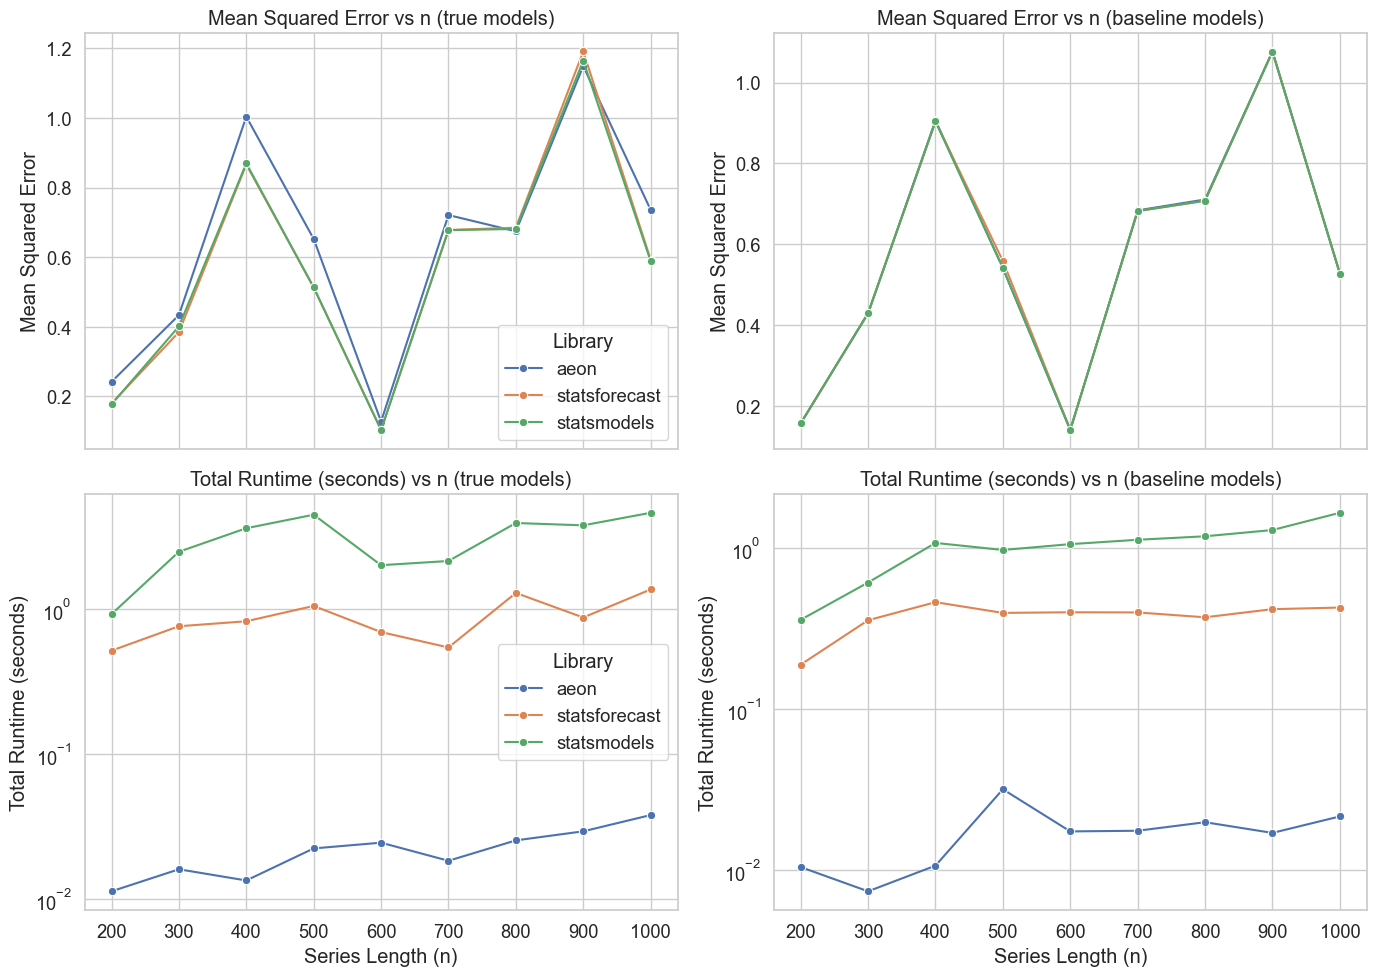

In [11]:
plot_mse_and_runtime_by_library(results)